In [51]:
import openpiv.tools
import openpiv.process
import openpiv.scaling
import openpiv.validation
import openpiv.filters

import h5py

from skimage import img_as_int

from imp import reload
import sys
sys.path.insert(0, '..')
import utilities as ut

import matplotlib.pyplot as plt

# Test OpenPIV on test tutorial data

In [9]:
frame_a = openpiv.tools.imread('../data/exp1_001_a.bmp')
frame_b = openpiv.tools.imread('../data/exp1_001_b.bmp')

/Users/morganschwartz/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


In [10]:
frame_a

array([[  8,   9,   7, ...,  77,  23,  12],
       [ 31,  20,  17, ...,  45,  26,  27],
       [ 20,  24,  23, ...,  70,  29,  25],
       ...,
       [ 10,   5,   9, ...,  57,  71,  14],
       [ 17,  21,  15, ...,  61, 119,  18],
       [ 50,  24,  12, ...,  49,  55,  15]], dtype=uint8)

Output of `openpiv.tools.imread` is a numpy array `uint8` so I should be able to read in my own data using different functions with a problem

In [12]:
frame_a.shape, frame_b.shape

((369, 511), (369, 511))

In [16]:
frame_a.dtype,frame_b.dtype

(dtype('uint8'), dtype('uint8'))

> This method is a zero order displacement predictor cross-correlation algorithm, which cope with the problem of loss of pairs when the interrogation window is small, by increasing the search area on the second image. We also provide some options to the function, namely the window_size, i.e. the size of the interrogation window on frame_a, the overlap in pixels between adjacent windows, the time delay in seconds dt between the two image frames an te size in pixels of the extended search area on frame_b. sig2noise_method specifies which method to use for the evalutaion of the signal/noise ratio. The function also returns a third array, sig2noise which contains the signal to noise ratio obtained from each cross-correlation function, intended as the ratio between the heigth of the first and second peaks ([Tutorial documentation](https://openpiv.readthedocs.io/en/latest/src/tutorial.html)).

In [13]:
openpiv.process.extended_search_area_piv?

Docstring:
The implementation of the one-step direct correlation with different 
size of the interrogation window and the search area. The increased
size of the search areas cope with the problem of loss of pairs due
to in-plane motion, allowing for a smaller interrogation window size,
without increasing the number of outlier vectors.

See:

Particle-Imaging Techniques for Experimental Fluid Mechanics

Annual Review of Fluid Mechanics
Vol. 23: 261-304 (Volume publication date January 1991)
DOI: 10.1146/annurev.fl.23.010191.001401    

Parameters
----------
frame_a : 2d np.ndarray, dtype=np.int32
    an two dimensions array of integers containing grey levels of 
    the first frame.
    
frame_b : 2d np.ndarray, dtype=np.int32
    an two dimensions array of integers containing grey levels of 
    the second frame.
    
window_size : int
    the size of the (square) interrogation window.
    
overlap : int
    the number of pixels by which two adjacent windows overlap.
    
dt : float
  

In [14]:
u,v,sig2noise = openpiv.process.extended_search_area_piv(frame_a, frame_b, window_size=24, 
                                                        overlap=12, dt=0.02, search_area_size=64,
                                                        sig2noise_method='peak2peak')

ValueError: Buffer dtype mismatch, expected 'DTYPEi_t' but got 'unsigned char'

```
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-14-54192111ef49> in <module>()
      1 u,v,sig2noise = openpiv.process.extended_search_area_piv(frame_a, frame_b, window_size=24, 
      2                                                         overlap=12, dt=0.02, search_area_size=64,
----> 3                                                         sig2noise_method='peak2peak')

openpiv/src/process.pyx in openpiv.process.extended_search_area_piv()

ValueError: Buffer dtype mismatch, expected 'DTYPEi_t' but got 'unsigned char'
```

[Tutorial documentation](https://openpiv.readthedocs.io/en/latest/src/tutorial.html) references the datatype of `frame_a` as `int32`, but currently the data in this notebook is `uint8`. Try converting to `int32` and see if it resolves the `extended_search_area_piv` error.

In [17]:
frame_a = frame_a.astype('int32')
frame_b = frame_b.astype('int32')

In [18]:
u,v,sig2noise = openpiv.process.extended_search_area_piv(frame_a, frame_b, window_size=24, 
                                                        overlap=12, dt=0.02, search_area_size=64,
                                                        sig2noise_method='peak2peak')

/Users/morganschwartz/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [19]:
type(u),type(v),type(sig2noise)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [20]:
u.shape, v.shape, sig2noise.shape

((29, 41), (29, 41), (29, 41))

> We then compute the coordinates of the centers of the interrogation windows using `openpiv.process.get_coordinates()`.

In [21]:
x, y = openpiv.process.get_coordinates( image_size=frame_a.shape, window_size=48, overlap=32 )

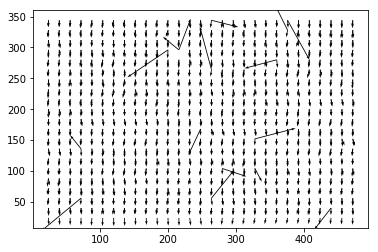

In [25]:
plt.quiver(x,y,u,v)

> Several outliers vectors can be observed as a result of the small interrogation window size and we need to apply a validation scheme. Since we have information about the signal to noise ratio of the cross-correlation function we can apply a well know filtering scheme, classifing a vector as an outlier if its signal to noise ratio exceeds a certain threshold. To accomplish this task we use the function:

In [28]:
u, v, mask = openpiv.validation.sig2noise_val( u, v, sig2noise, threshold = 1.3 )

> with a threshold value set to 1.3. This function actually sets to NaN all those vector for which the signal to noise ratio is below 1.3. Therefore, the arrays u and v contains some np.nan elements. Furthermore, we get in output a third variable mask, which is a boolean array where elements corresponding to invalid vectors have been replace by Nan. The result of the filtering is shown in the following image, which we obtain with the two commands:

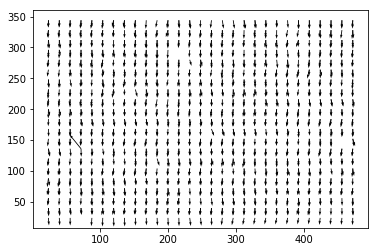

In [29]:
plt.quiver(x,y,u,v)

> The final step is to replace the missing vector. This is done which the function openpiv.filters.replace_outliers(), which implements an iterative image inpainting algorithm with a specified kernel. We pass to this function the two velocity components arrays, a method type localmean, the number of passes and the size of the kernel.:

In [33]:
openpiv.filters.replace_outliers?

Signature: openpiv.filters.replace_outliers(u, v, method='localmean', max_iter=5, tol=0.001, kernel_size=1)
Docstring:
Replace invalid vectors in an velocity field using an iterative image inpainting algorithm.

The algorithm is the following:

1) For each element in the arrays of the ``u`` and ``v`` components, replace it by a weighted average
   of the neighbouring elements which are not invalid themselves. The weights depends
   of the method type. If ``method=localmean`` weight are equal to 1/( (2*kernel_size+1)**2 -1 )
   
2) Several iterations are needed if there are adjacent invalid elements.
   If this is the case, inforation is "spread" from the edges of the missing
   regions iteratively, until the variation is below a certain threshold. 

Parameters
----------

u : 2d np.ndarray
    the u velocity component field
    
v : 2d np.ndarray
    the v velocity component field
    
max_iter : int
    the number of iterations
fil
kernel_size : int
    the size of the kernel, default

In [34]:
u, v = openpiv.filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2 )

> The last step is to apply an uniform scaling to the flow field to get dimensional units. We use the function openpiv.scaling.uniform() providing the scaling_factor value, in pixels per meters if we want position and velocities in meters and meters/seconds or in pixels per millimeters if we want positions and velocities in millimeters and millimeters/seconds, respectively.

In [35]:
x, y, u, v = openpiv.scaling.uniform(x, y, u, v, scaling_factor = 96.52 )

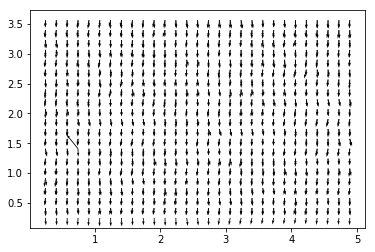

In [36]:
plt.quiver(x,y,u,v)

# Test on 2 timepoints from our brightfield data

In [43]:
hst = ut.read_hyperstack('../data/wt_gbe_20180110_mask.h5')[:,300:800,:]

In [49]:
t1_raw = hst[0]
t2_raw = hst[1]

(None, None)

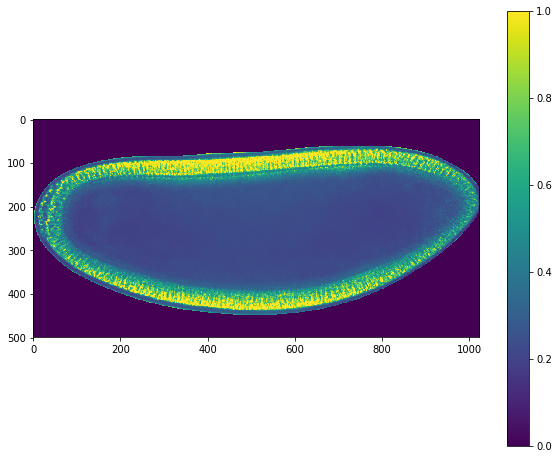

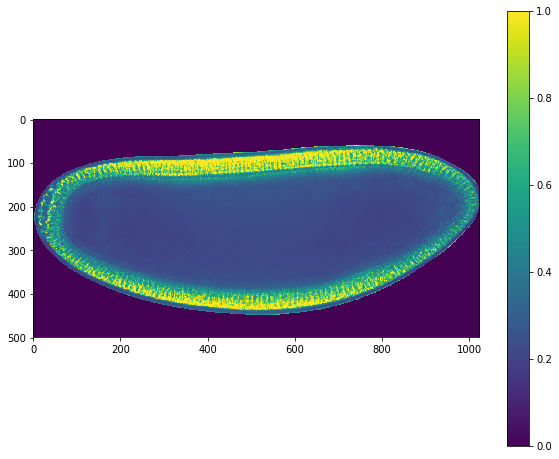

In [50]:
ut.imshow(t1_raw),ut.imshow(t2_raw)

Check that dtype is `int32` to be compatible with `openpiv`

In [46]:
t1_raw.dtype,t2_raw.dtype

(dtype('float64'), dtype('float64'))

For the purpose of this test, we will just cast the data to type `int32`, but in the future this conversion needs to be carefully handled to avoid loss of data.

(None, None)

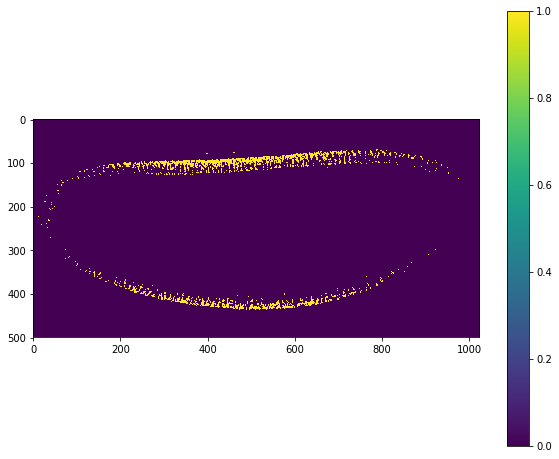

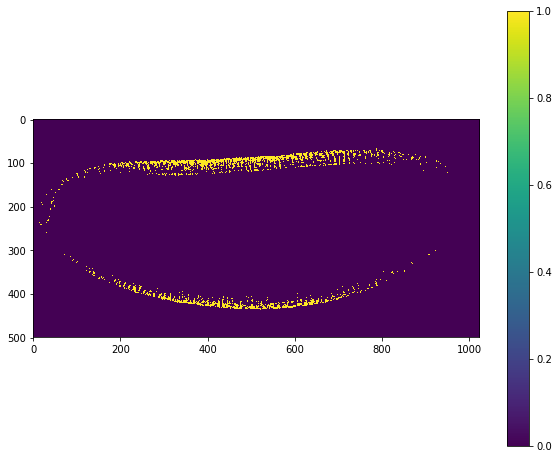

In [48]:
t1 = t1_raw.astype('int32')
t2 = t2_raw.astype('int32')
ut.imshow(t1),ut.imshow(t2)

Clearly using `numpy.astype` results in a dramatic loss of data. Instead, we'll try using `skimage.img_as_int` before converting to type `int32`.

/Users/morganschwartz/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to int16
  .format(dtypeobj_in, dtypeobj_out))


(None, None)

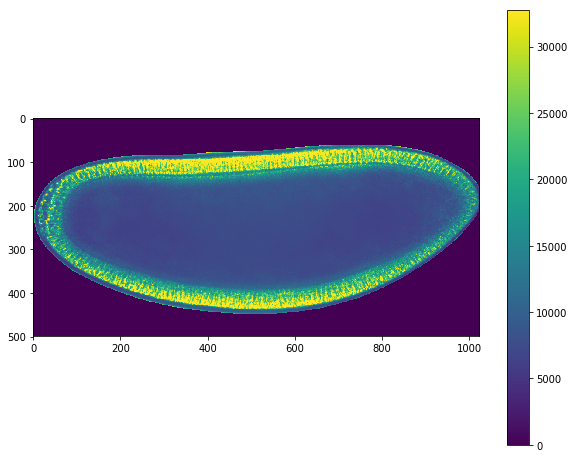

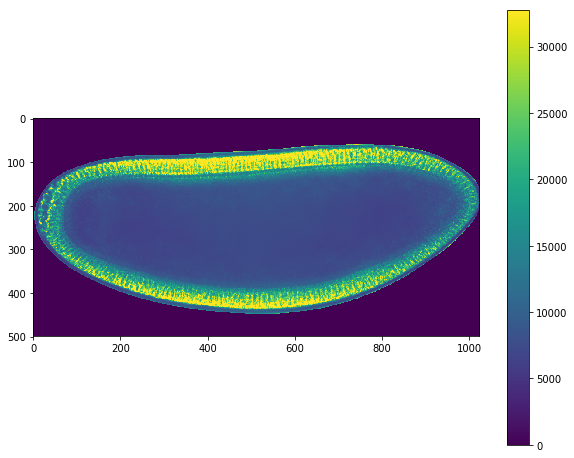

In [52]:
t1 = img_as_int(t1_raw).astype('int32')
t2 = img_as_int(t2_raw).astype('int32')
ut.imshow(t1),ut.imshow(t2)

This conversion looks much better and avoids qualitatively obvious losses in data. In our first attempt to run `openpiv.process.extended_search_area_piv`, we will use the parameter values from the tutorial, but there is no reason to expect that these are appropriate given that our data are much larger in size than the tutorial data.

In [53]:
u,v,sig2noise = openpiv.process.extended_search_area_piv(t1, t2, window_size=24, 
                                                        overlap=12, dt=0.02, search_area_size=64,
                                                        sig2noise_method='peak2peak')

/Users/morganschwartz/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
/Users/morganschwartz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
x, y = openpiv.process.get_coordinates( image_size=t1.shape, window_size=48, overlap=32 )

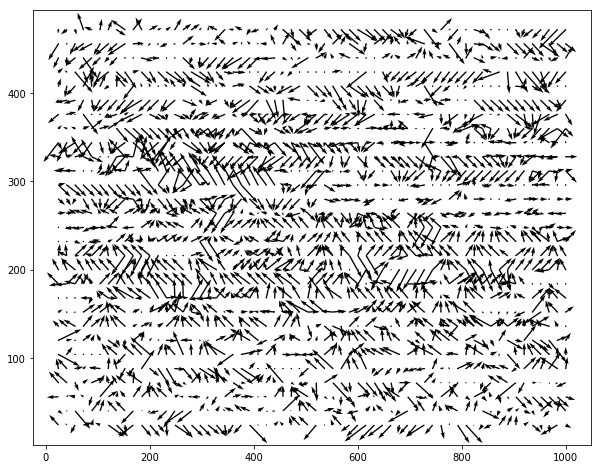

In [58]:
fig,ax = plt.subplots(figsize=(10,8))
ax.quiver(x,y,u,v)